<a href="https://colab.research.google.com/github/aidannguyen23/PowerPlant-Energy-Prediction/blob/main/CCPP_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [6]:
df = pd.read_excel("/content/drive/MyDrive/Folds5x2_pp.xlsx")

In [14]:
df = df.rename(columns={'AT' : 'Temperature'})
df = df.rename(columns={'V' : 'Exhaust Vacuum'})
df = df.rename(columns={'RH' : 'Relative Humidity'})
df = df.rename(columns={'AP' : 'Ambient Pressure'})
df = df.rename(columns={'PE' : 'Energy Output'})

In [19]:
# Reorder the columns with target variable (Energy Output) at the front
new_order = ['Energy Output'] + [col for col in df.columns if col != 'Energy Output']
df = df[new_order]

In [20]:
df.head()

,Energy Output,Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity
0,463.26,14.96,41.76,1024.07,73.17
1,444.37,25.18,62.96,1020.04,59.08
2,488.56,5.11,39.40,1012.16,92.14
3,446.48,20.86,57.32,1010.24,76.64
4,473.90,10.82,37.50,1009.23,96.62


In [ ]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["Energy Output"])
  plt.title(label)
  plt.ylabel("Energy Output")
  plt.xlabel(label)
  plt.show()

# Train/Valid/Test Dataset

In [24]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [47]:
def get_xy(dataframe, y_label, x_labels = None):
  dataframe = copy.deepcopy(dataframe) # copy everything over
  if x_labels is None: # take all columns if no x_labels
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)  #make it 2d so we can hstack
  data = np.hstack((X, y))

  return data, X, y

In [ ]:
_, X_train_temp, y_train_temp = get_xy(train, "Energy Output", x_labels=["Temperature"])
_, X_val_temp, y_val_temp = get_xy(val, "Energy Output", x_labels=["Temperature"])
_, X_test_temp, y_test_temp = get_xy(test, "Energy Output", x_labels=["Temperature"])

# Standard Linear Regression

In [30]:
temp_regressor = LinearRegression()
temp_regressor.fit(X_train_temp, y_train_temp)

LinearRegression()

In [31]:
print(temp_regressor.coef_, temp_regressor.intercept_) # coefficient and intercept for R^2

[[-2.15987627]] [496.83064528]


In [33]:
temp_regressor.score(X_test_temp, y_test_temp) # 0.898, good correlation

0.8983759042549275

Text(0.5, 0, 'Temperature')

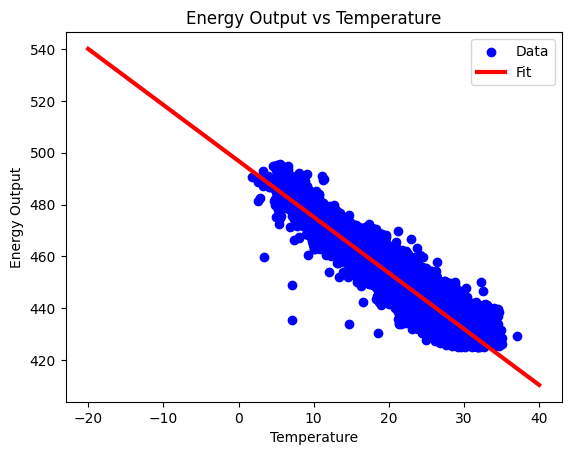

In [45]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_regressor.predict(np.array(x).reshape(-1, 1)), label="Fit", color = "red", linewidth=3) # reshape into 2d array
plt.legend()
plt.title("Energy Output vs Temperature")
plt.ylabel("Energy Output")
plt.xlabel("Temperature")

#Multiple Linear Regression

In [46]:
df.columns

Index(['Energy Output', 'Temperature', 'Exhaust Vacuum', 'Ambient Pressure',
       'Relative Humidity'],
      dtype='object')

In [49]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [195]:
_, X_train_all, y_train_all = get_xy(train, "Energy Output", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "Energy Output", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "Energy Output", x_labels=df.columns[1:])

In [ ]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

In [52]:
all_reg.score(X_test_all, y_test_all) # 0.926, even better prediction than standard linear regression (0.898)

0.9268105725298109

# Standard Regression with Neural Network

In [160]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [138]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None) # create normalizer layer, shape is 1 because just for tempearture
temp_normalizer.adapt(X_train_temp.reshape(-1)) # reshape to a single vector

In [139]:
import tensorflow as tf

# Define L1 or L2 regularized Dense layer
regularized_layer = tf.keras.layers.Dense(1,
    kernel_regularizer=tf.keras.regularizers.l1(0.1)
)

# Construct the model
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    regularized_layer,
])

# Define EarlyStopping callback with patience
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop training if no improvement after 5 epochs
    restore_best_weights=True  # Restore best weights based on validation loss
)


In [220]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [221]:
history = temp_nn_model.fit( # fit the model
    X_train_temp.reshape(-1), y_train_temp,
    verbose = 0,
    epochs = 50,
    validation_data = (X_val_temp, y_val_temp)
)

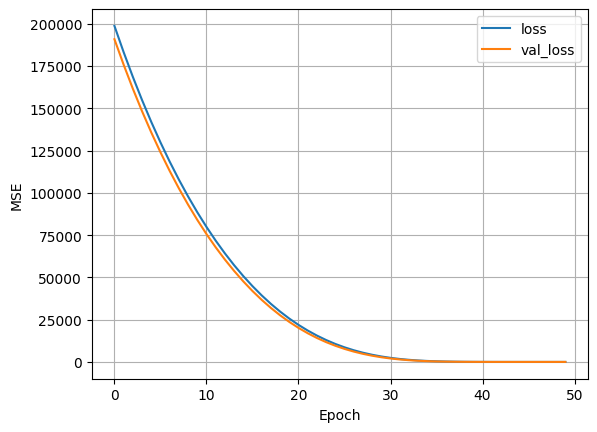

In [142]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


Text(0.5, 0, 'Temperature')

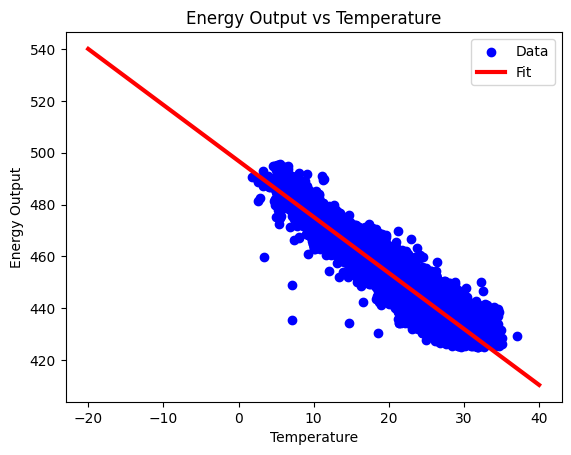

In [143]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color = "red", linewidth=3) # reshape into 2d array
plt.legend()
plt.title("Energy Output vs Temperature")
plt.ylabel("Energy Output")
plt.xlabel("Temperature")

# Multiple Regression with Neural Network

In [205]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [206]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(4,), axis=None) # create normalizer layer, shape is 1 because just for tempearture
all_normalizer.adapt(X_train_all.reshape(-1)) # reshape to a single vector

In [207]:
import tensorflow as tf

# Define L1 or L2 regularized Dense layer
regularized_layer = tf.keras.layers.Dense(1,
    kernel_regularizer=tf.keras.regularizers.l1(0.1)
)

# Construct the model
all_nn_model = tf.keras.Sequential([
    all_normalizer,
    regularized_layer,
])

# Define EarlyStopping callback with patience
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop training if no improvement after 5 epochs
    restore_best_weights=True  # Restore best weights based on validation loss
)


In [208]:
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [210]:
# For Normalization layers, ensure consistency in adaptation:
all_normalizer.adapt(X_train_all.reshape(-1))

history = all_nn_model.fit(
    X_train_all, y_train_all,
    verbose=0,
    epochs=50,
    validation_data=(X_val_all, y_val_all)
)


(5740, 4) (5740, 1)
(1914, 4) (1914, 1)
(5740, 4) (5740, 1)
(1914, 4) (1914, 1)


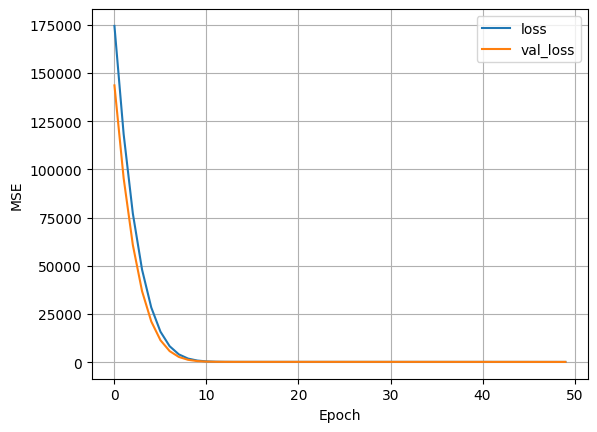

In [211]:
plot_loss(history)

# Conclusions

In [ ]:
# calculating the MSE for both linear regression and neural network
y_pred_linear_regression = all_reg.predict(X_test_all)
y_pred_neural_network = all_nn_model.predict(X_test_all)

In [215]:
def MSE(y_pred, y_real) :
    return (np.square(y_pred - y_real)).mean()

In [216]:
MSE(y_pred_linear_regression, y_test_all)

21.713023164572924

In [217]:
MSE(y_pred_neural_network, y_test_all)

162.79878582524233

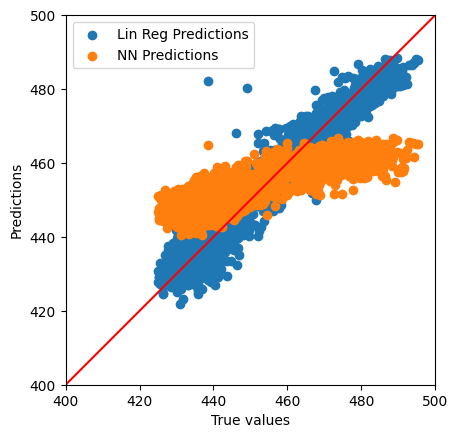

In [218]:
ax = plt.axes(aspect = "equal")
plt.scatter(y_test_all, y_pred_linear_regression, label = "Lin Reg Predictions")
plt.scatter(y_test_all, y_pred_neural_network, label = "NN Predictions")
plt.xlabel("True values")
plt.ylabel("Predictions")
lims = [400, 500]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")